# Linear Regression

In this lab we set up a basic linear regression and explore different loss functions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.model_selection import KFold
from sklearn import linear_model #New!
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

font = {'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
#matplotlib.rcParams.update({'figure.autolayout': False})
matplotlib.rcParams['figure.dpi'] = 300

#### We begin by generating some data.

In [2]:
np.random.seed(16) #set seed for reproducibility purposes
x = np.arange(100) 
yp = 3*x + 3 + 2*(np.random.poisson(3*x+3,100)-(3*x+3)) #generate some data with scatter following Poisson distribution 
                                                        #with exp value = y from linear model, centered around 0

## Step 1: sklearn's regression

Set up a linear regression model using *LinearRegression()*. Fit to the data, print the slope and intercept. (When only one predictor is present, you need to reshape it to column form.) Plot the data in a scatter plot, add the fit line and the "true" regression line y=3x+3.

Now plot the residuals, i.e. the difference between true regression line and actual data. Are the residuals independent of x? What does this mean? 

We can see that they are not independent of x (the assumptions of the probabilistic linear model are not satisfied). But that doesn't mean we can't create a model.

Slope: [3.02475848]
Intercept: [-0.12554455]


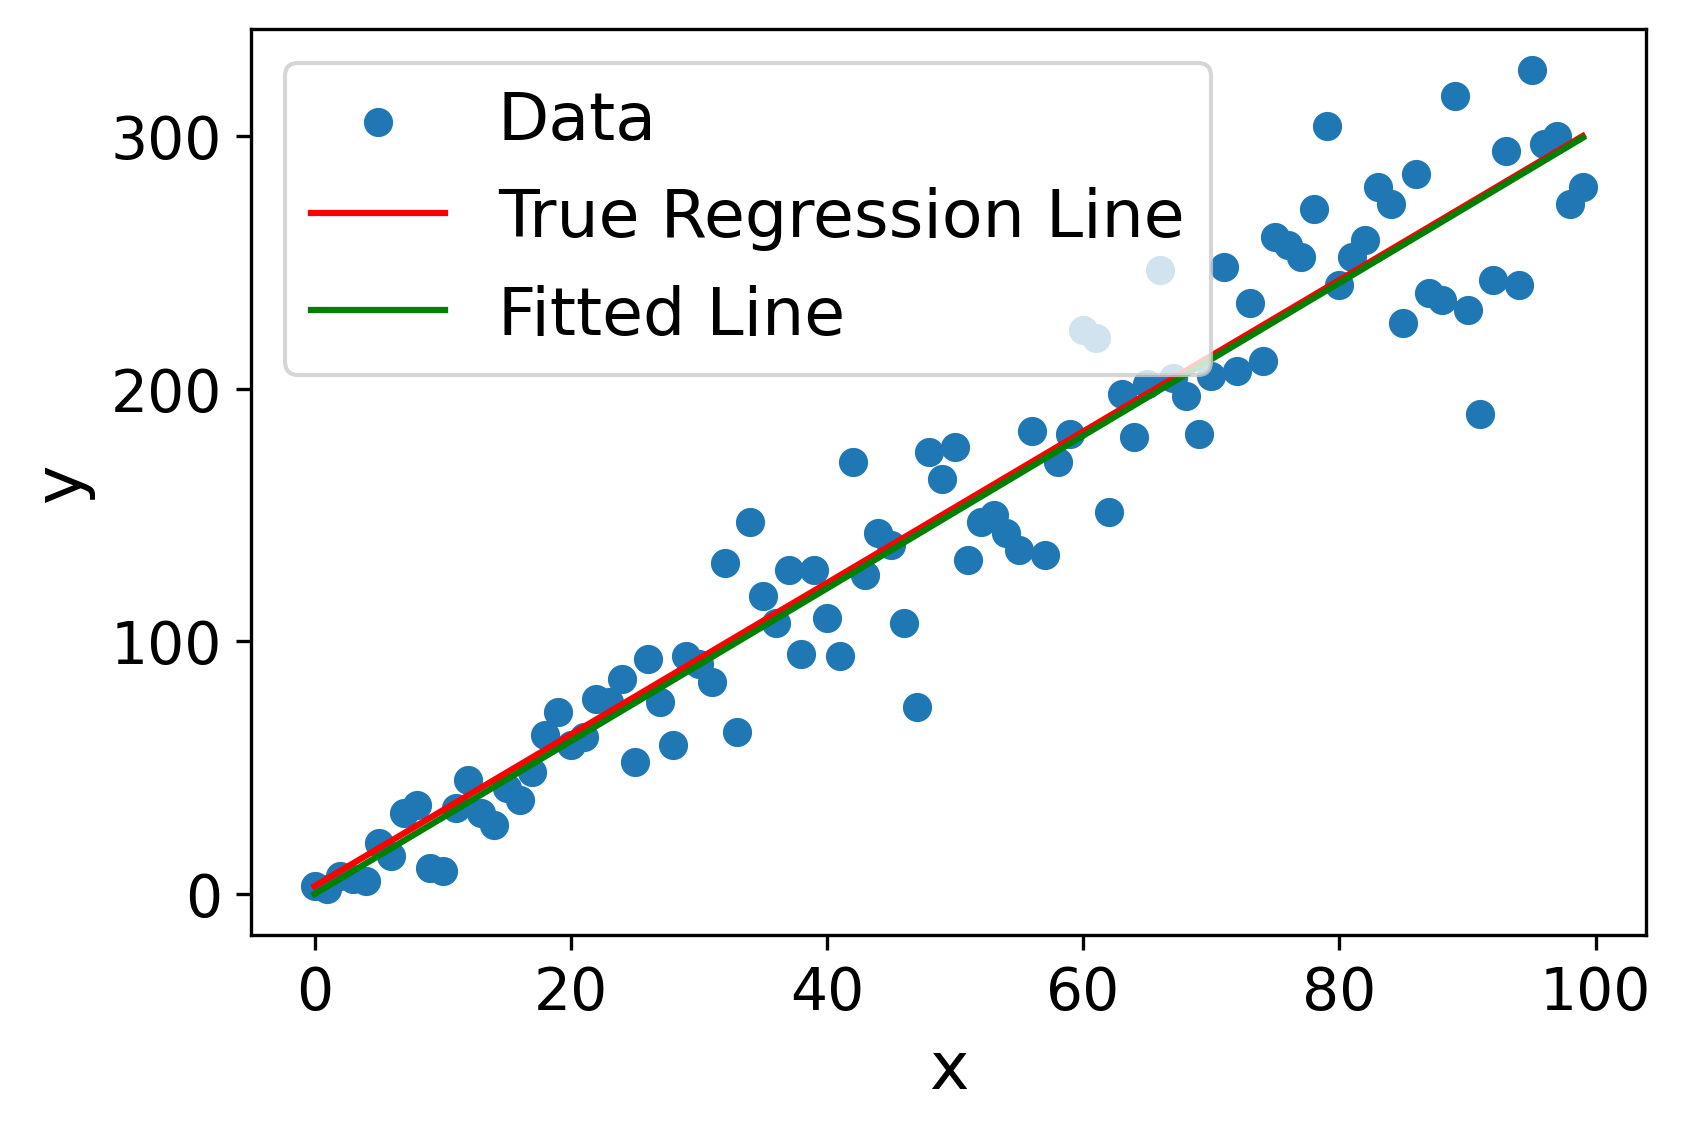

In [3]:
model = LinearRegression()

reg = model.fit(x.reshape(-1, 1), yp.reshape(-1, 1))

print("Slope:", model.coef_[0])
print("Intercept:", model.intercept_)

plt.scatter(x, yp, label='Data')
plt.plot(x, 3*x + 3, color='red', label='True Regression Line')
plt.plot(x, model.predict(x.reshape(-1, 1)), color='green', label='Fitted Line')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

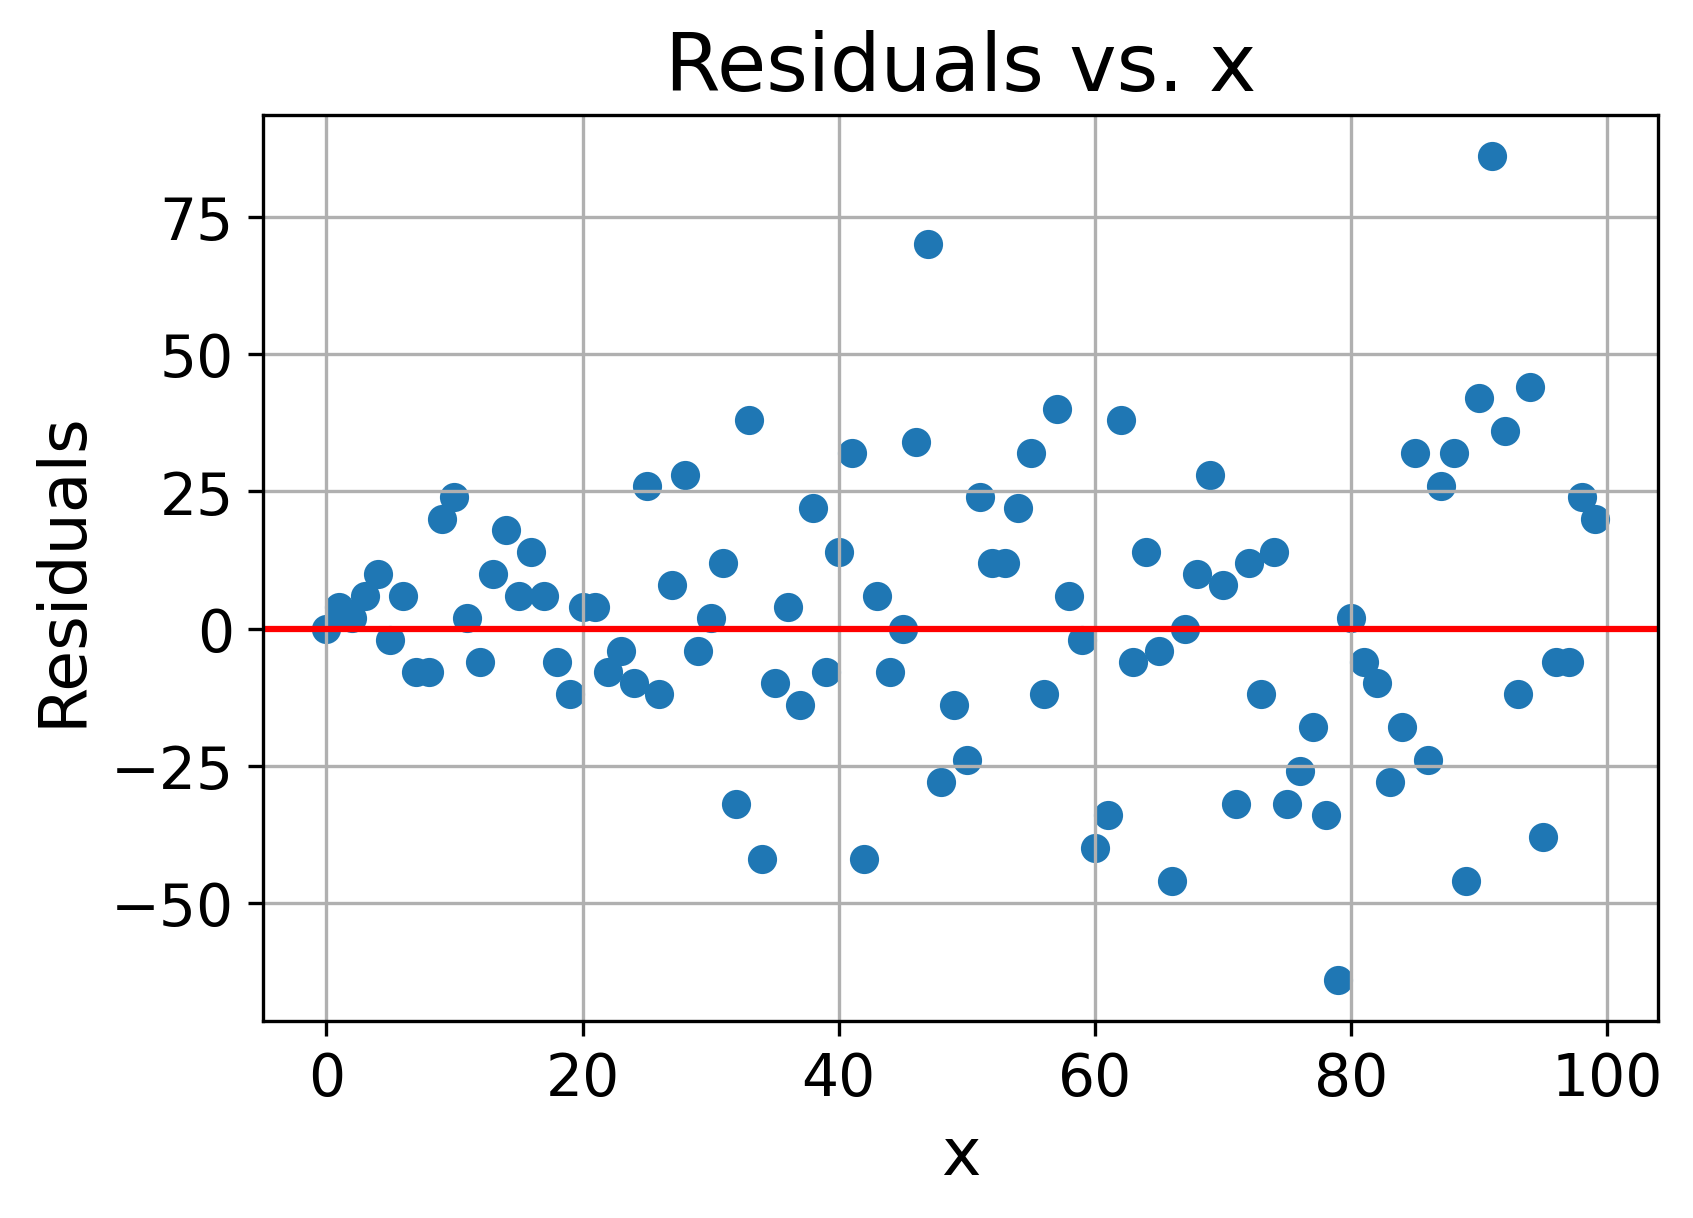

In [4]:
pred = model.predict(x.reshape(-1, 1))

residuals = 3*x + 3 - yp
plt.scatter(x.flatten(), residuals)


plt.xlabel('x')
plt.ylabel('Residuals')
plt.title('Residuals vs. x')
plt.axhline(y=0, color='r', linestyle='-')
plt.grid()
plt.show()

- **the residual seems to increase as x increases, this could be due to violations of the assumptions of the linear model or other factors influencing the data**

## Step 2: Analytic solutions

What are the analytic predictions for the coefficients? We can approach this in different ways:

1) Since this is a one-dimensional case, we can use formulas (5.7) and (5.9) to compute slope and intercept.
2) We can also use the covariance formula (5.10) for the slope
3) Finally we can set up the more general "normal" equation (5.13) using linear algebra tools from numpy. (Note: you need to append an additional feature x0=1  to all instances of the feature matrix X, because otherwise we would ignore the bias parameter in our calculation. *np.c_* can be useful.)

Please try all three options:

In [7]:
#1)
x_mean = np.mean(x)
yp_mean = np.mean(yp)

slope_formula = np.sum(x*(yp-yp_mean))/np.sum(x*(x-x_mean))
intercept_formula = yp_mean - slope_formula * x_mean
print(f"Slope (Formula): {slope_formula}, Intercept (Formula): {intercept_formula}")

#2)
cov_xy = np.sum((x-x_mean)*(yp-yp_mean))/len(x)
var_x = np.sum((x-x_mean)**2)/len(x)

slope_covariance = cov_xy / var_x
print(f"Slope (Covariance): {slope_covariance}")

#3)
X = np.c_[np.ones_like(x.reshape(-1,1)), (x.reshape(-1,1))]
coefficients_normal = np.linalg.inv(X.T @ X) @ X.T @ yp

intercept_normal, slope_normal = coefficients_normal[0], coefficients_normal[1]
print(f"Slope (Normal Equation): {slope_normal}, Intercept (Normal Equation): {intercept_normal}")

Slope (Formula): 3.0247584758475847, Intercept (Formula): -0.12554455445544477
Slope (Covariance): 3.0247584758475847
Slope (Normal Equation): 3.0247584758475856, Intercept (Normal Equation): -0.12554455445542523


## Step 3: Cross-validation

We can (and should!) do cross validation and all the nice things we have learned to do for classification problems. Set up k-fold cross-validation with five folds, the default metric and return_train_score=True. Compute the mean and standard deviation of test and train scores

In [114]:
cv = KFold(n_splits=5, shuffle=True)
results = cross_validate(model, x.reshape(-1,1), yp, cv=cv, return_train_score=True)

train_scores = cv_results['train_score']
test_scores = cv_results['test_score']

mean_train_score = np.mean(train_scores)
std_train_score = np.std(train_scores)

mean_test_score = np.mean(test_scores)
std_test_score = np.std(test_scores)

print(f"Mean Train Score: {mean_train_score}, Std Train Score: {std_train_score}")
print(f"Mean Test Score: {mean_test_score}, Std Test Score: {std_test_score}")

Mean Train Score: 0.9247009939488438, Std Train Score: 0.00722443239474993
Mean Test Score: 0.9029006135922467, Std Test Score: 0.05927860892570733


### Questions: 

- What are the scores that are being printed out?
-- Print above^

- How are the scores? 
-- The model seems to perform well and both training and tests sets, as both mean scores are high with low std.

- Does it suffer from high variance? High bias?
-- There seems to be low varience, as the std in the test score is low. The bias is also not high as the test score is high

- What would happen to the scores if we increased the scatter (noise)?
-- This would lead to an increase in std of the test scores. As there would be more noise making it harder for the model to generlaize well to unseen data

## Step 4: Scoring

sklearn has many possible scoring functions available, see https://scikit-learn.org/stable/modules/model_evaluation.html
Repeat step 3 with mean squared error and mean absolute error as scoring functions.

Something to note is that estimators of performance of the "error" type (in other words, the lower, the better) receive a negative sign in sklearn. This is just to maintain consistency with the "higher score = better" framework.

In [66]:
results_mse = cross_validate(model, x.reshape(-1,1), yp, cv=cv, return_train_score=True,\
                             scoring='neg_mean_squared_error')

train_scores_mse = -results_mse['train_score']
test_scores_mse = -results_mse['test_score']

mean_train_score_mse = np.mean(train_scores_mse)
std_train_score_mse = np.std(train_scores_mse)

mean_test_score_mse = np.mean(test_scores_mse)
std_test_score_mse = np.std(test_scores_mse)

print(f"Mean Train Score: {mean_train_score_mse}, Std Train Score: {std_train_score_mse}")
print(f"Mean Test Score: {mean_test_score_mse}, Std Test Score: {std_test_score_mse}")

Mean Train Score: 615.929690199814, Std Train Score: 44.849248224337195
Mean Test Score: 633.9643144808485, Std Test Score: 179.77330067117884


In [84]:
results_mae = cross_validate(model, x.reshape(-1,1), yp, cv=cv,return_train_score=True, \
                             scoring='neg_mean_absolute_error')

train_scores_mae = -results_mae['train_score']
test_scores_mae = -results_mae['test_score']

mean_train_score_mae = np.mean(train_scores_mae)
std_train_score_mae = np.std(train_scores_mae)

mean_test_score_mae = np.mean(test_scores_mae)
std_test_score_mae = np.std(test_scores_mae)

print(f"Mean Train Score: {mean_train_score_mae}, Std Train Score: {std_train_score_mae}")
print(f"Mean Test Score: {mean_test_score_mae}, Std Test Score: {std_test_score_mae}")

Mean Train Score: 18.926935526063083, Std Train Score: 0.8591226886120805
Mean Test Score: 19.067384334677318, Std Test Score: 3.2973278085770157


### Custom scores

We might like to implement a scorer where we care about percentage error instead. Here is how to do a custom scorer. Check it out on the data from above.

In [71]:
from sklearn.metrics import make_scorer

In [72]:
def mape(true,pred): #Modified Mean Absolute Percentage Error
    return np.mean(np.abs((true-pred)/(0.5*(true+pred))))

mape_scorer = make_scorer(mape, greater_is_better = False)

In [78]:
results_custom = cross_validate(model, x.reshape(-1, 1), yp, cv=cv, return_train_score=True, scoring=mape_scorer)

train_scores_custom = results_custom['train_score']
test_scores_custom = results_custom['test_score']

mean_train_score_custom = -np.mean(train_scores_custom)
std_train_score_custom = -np.std(train_scores_custom)

mean_test_score_custom = np.mean(test_scores_custom)
std_test_score_custom = np.std(test_scores_custom)

print(f"Mean Train Score: {mean_train_score_custom}, Std Train Score: {std_train_score_custom}")
print(f"Mean Test Score: {mean_test_score_custom}, Std Test Score: {std_test_score_custom}")

Mean Train Score: 0.21248625673555638, Std Train Score: -0.04612227057918255
Mean Test Score: -0.19039427642047196, Std Test Score: 0.03966287078417804


## Step 5:  What happens when we add outliers?

In [79]:
np.random.seed(12) #set 
out = np.random.choice(100,15) #select 15 outliers indexes
yp_wo = np.copy(yp)
np.random.seed(12) #set again
yp_wo[out] = yp_wo[out] + 5*np.random.rand(15)*yp[out]

Re-fit the linear model to the new data and plot the original data, the new data and the new fit line in a scatter plot.

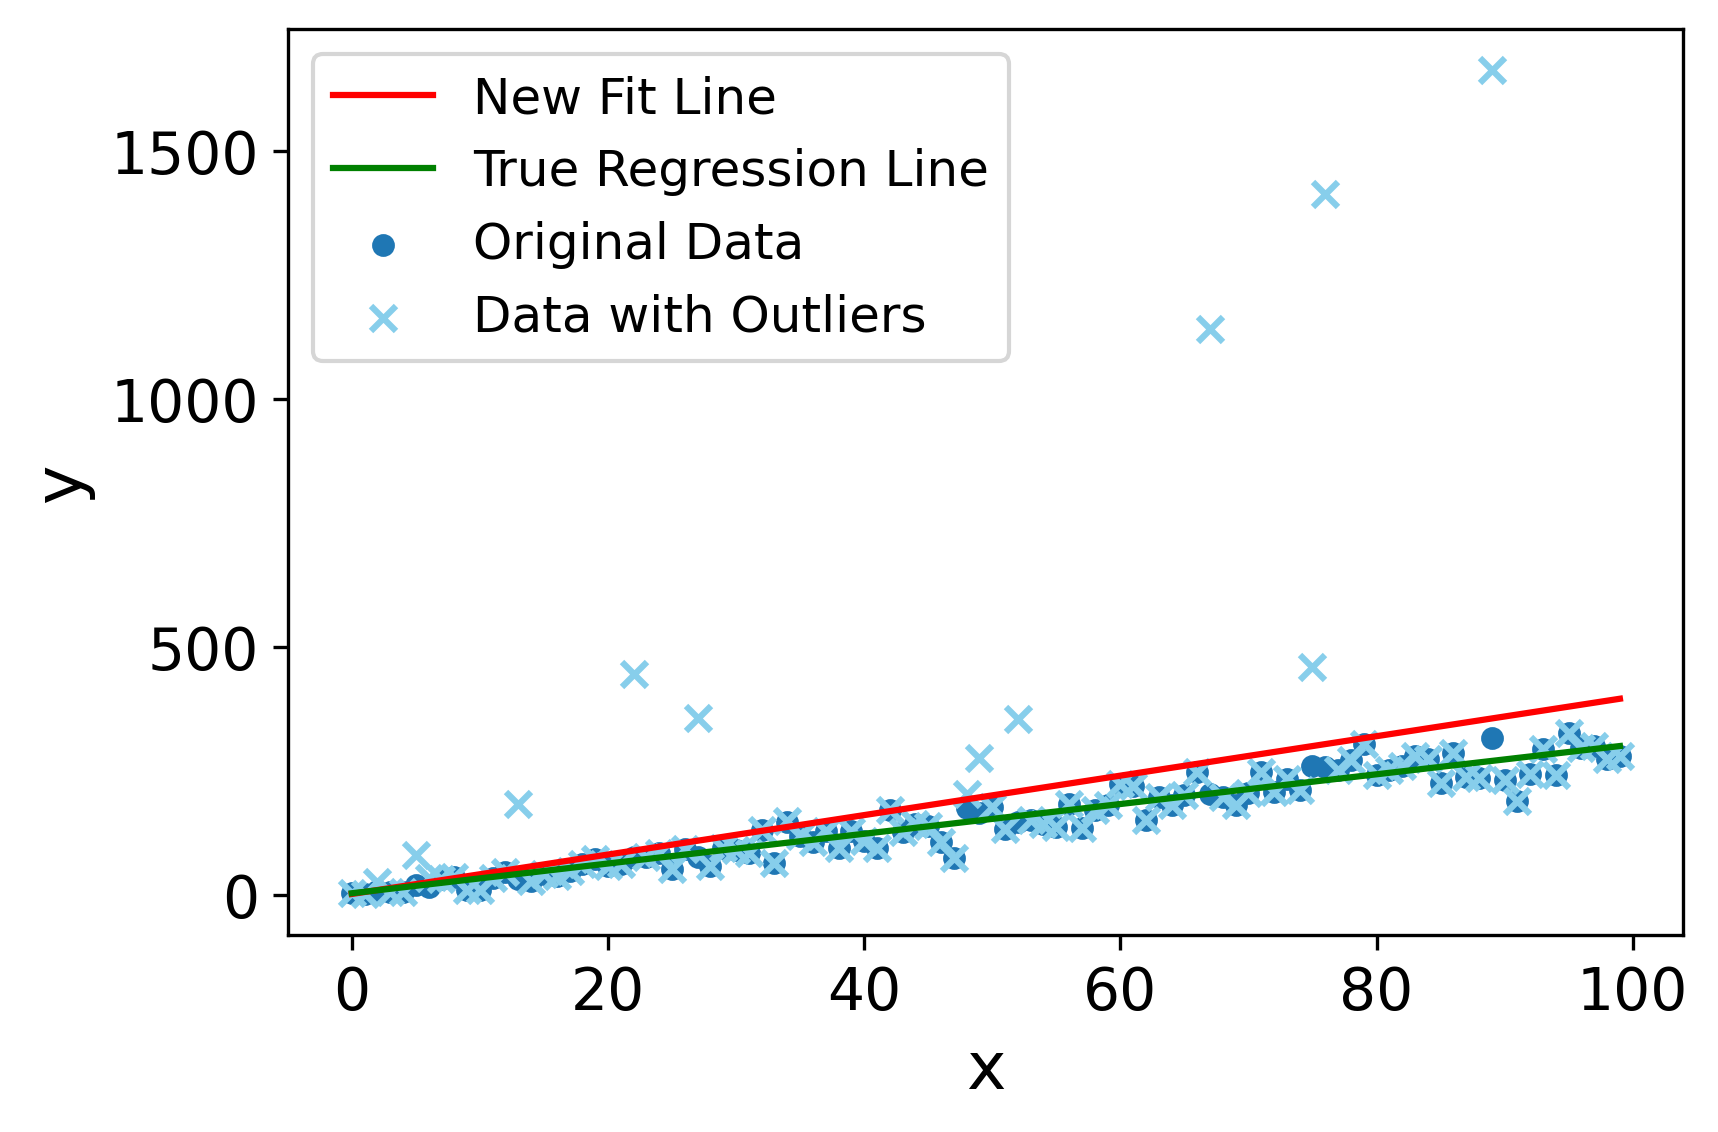

In [112]:
model.fit(x.reshape(-1,1), yp_wo)

plt.scatter(x, yp, label='Original Data', s=20)
plt.scatter(x, yp_wo, label='Data with Outliers', marker='x', color="skyblue")
plt.plot(x, model.predict(x.reshape(-1,1)), color='red', label='New Fit Line')
plt.plot(x, 3*x + 3, color='green', label='True Regression Line')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(fontsize=12)
plt.show()

#### Note: as we already discussed, so far we have not changed the loss function (MSE), or the coefficients of the model. We have only looked at different evaluation metrics.

Question 1: Would the best fit line change if we optimize a different loss function? </font>

- **Yes, the best fit line would change as we optimize a different loss function. The loss function influences the models learning process and thus the coefficients of the model**

Question 2: How can we implement that without an analytic solution? </font>
- **You can use gradient-based optimization algorithms**

## Step 6: Change the loss function

1. Calculate the best fitting coefficients for the MAE (mean absolute error) and compare to the MSE for the data with outliers. You can use a simple grid search as in week 1. Another option is to use *minimize* from *scipy.optimize* to find the coefficients that minmize the different loss functions.

2. Plot the data and the best fits.

3. Explain the results by commenting on the differences.

If you have time, try also computing the Huber loss as a hybrid between MSE and MAE (behaves like MAE when the error is larger than a certain amount, often called delta, so it's less sensitive to outliers). One possibility is to use the std of the y values to set delta.

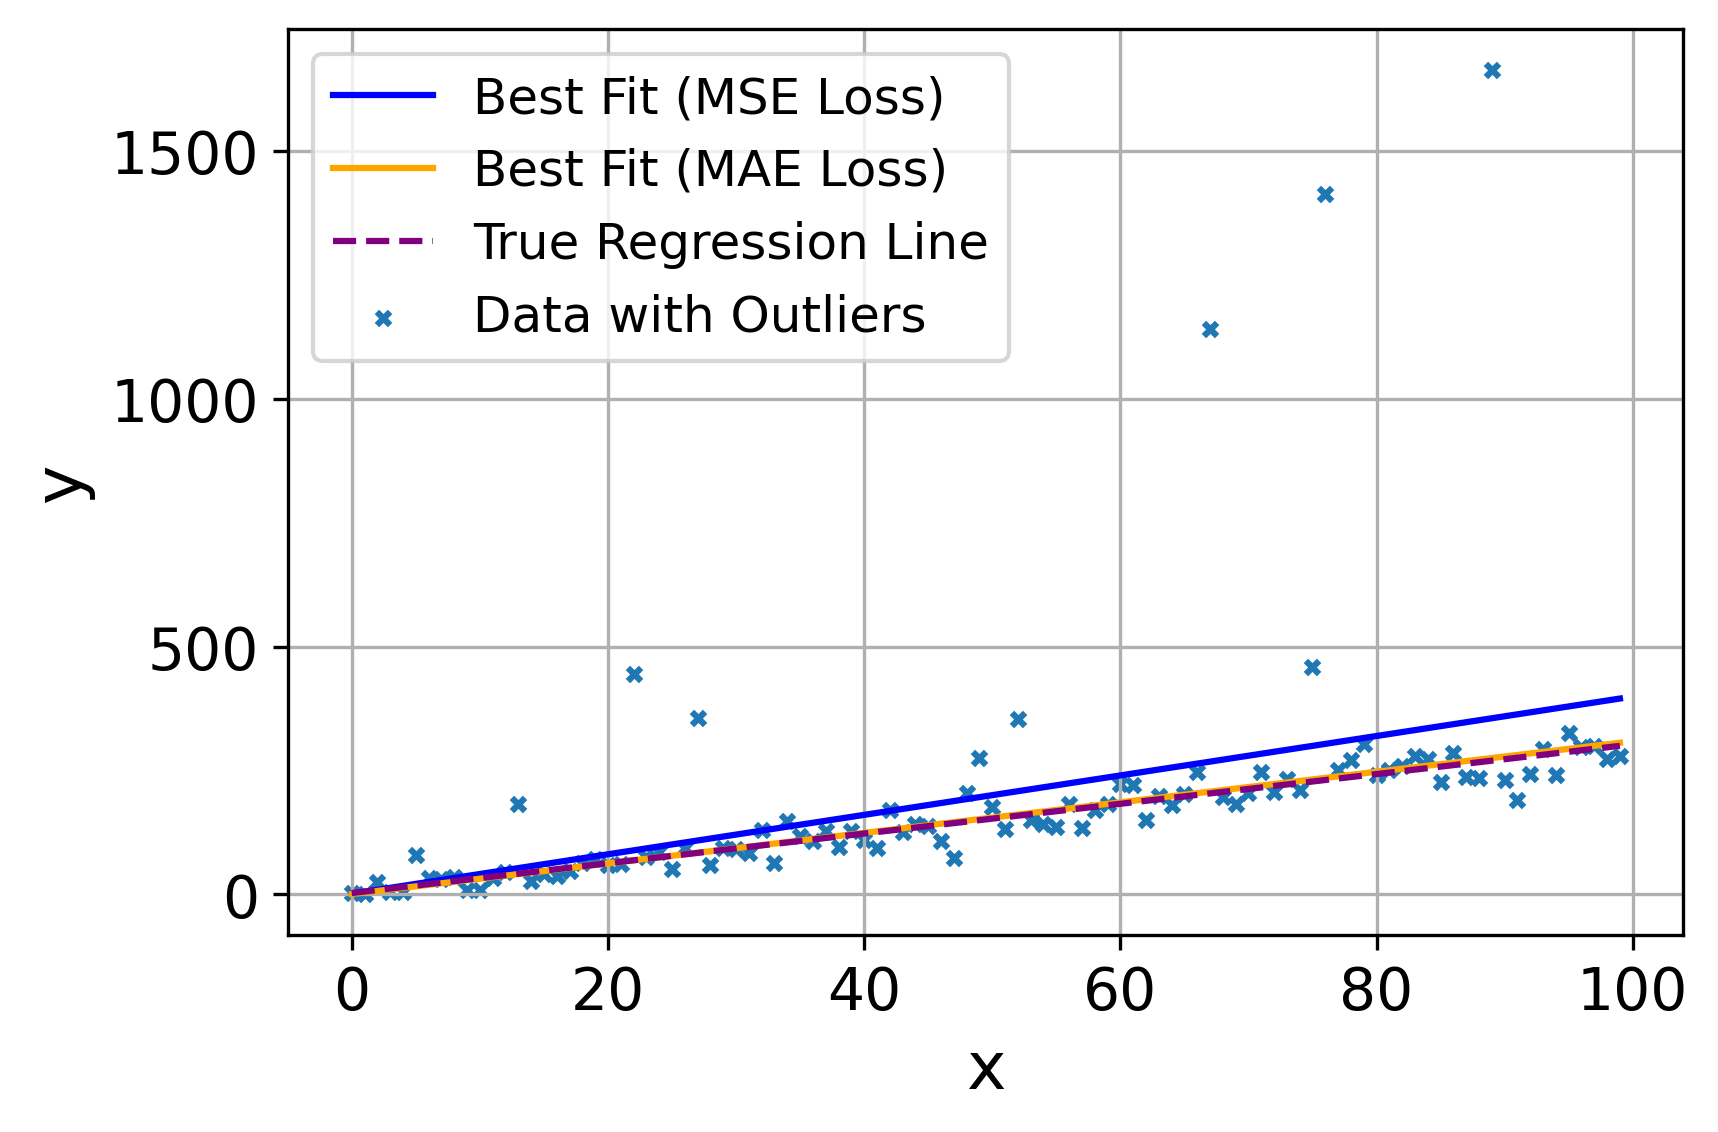

In [104]:
def mse_loss(params, x, y):
    slope, intercept = params
    predicted = slope * x + intercept
    return np.mean((y - predicted)**2)

def mae_loss(params, x, y):
    slope, intercept = params
    predicted = slope * x + intercept
    return np.mean(np.abs(y - predicted))

initial_guess = [1, 1]

mse_result = minimize(mse_loss, initial_guess, args=(x, yp_wo))
slope_mse, intercept_mse = mse_result.x

mae_result = minimize(mae_loss, initial_guess, args=(x, yp_wo))
slope_mae, intercept_mae = mae_result.x

plt.scatter(x, yp_wo, label='Data with Outliers', marker='x', s=10)
plt.plot(x, slope_mse * x + intercept_mse, color='blue', label='Best Fit (MSE Loss)')
plt.plot(x, slope_mae * x + intercept_mae, color='orange', label='Best Fit (MAE Loss)')
plt.plot(x, 3*x + 3, linestyle='dashed', color='purple', label='True Regression Line')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(fontsize=12)
plt.grid()
plt.show()

- **MSE is more sensitive to outliers, as it penalizes large errors more than MAE. Which is why you can see the blue line is higher than the orange line**
- **MAE is better with data points with lots of noise**